## Preprocessing version 5
### Details
this version 
- uses all data
- has validation split
- uses bert tokenizer
- does not train embedding

In [1]:
doc_name = "/home/b05902064/pointer-generator/data/train.article.txt"
summ_name = "/home/b05902064/pointer-generator/data/train.title.txt"
out_dir = "data-giga/"
vocab_name = out_dir+"vocab.json"
data_seq_name = out_dir+"train_seq.json"
valid_seq_name = out_dir+"valid_seq.json"
task_name = "giga"
num_threads = 6
corpus_size = 88888888
validation_split = 0.002

In [2]:
import os
import csv
import json
import numpy as np
from pytorch_pretrained_bert.tokenization import BertTokenizer
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool

In [3]:
# !pip install --user pytorch_pretrained_bert
# !pip install --user gensim

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# "[UNK]", "[SEP]", "[PAD]", "[CLS]", "[MASK]"
UNK = "[UNK]"
BOS = "[CLS]"
EOS = "[SEP]"
PAD = "[PAD]"

In [5]:
json.dump(tokenizer.vocab, open(vocab_name, "w"))

In [6]:
if task_name == 'giga':
    token_mappings = {'UNK':UNK, '-lrb-':'(', '-rrb-':')'}
else:
    token_mappings = {'<unk>':UNK, '<t>':'', '</t>':''}

In [7]:
def getlines(name):
    total = !wc -l {name}
    return int(total[0].split()[0])

In [8]:
summaries = []
articles = []

with open(doc_name, newline='', encoding='utf-8') as f:
    total = getlines(doc_name)
    for i,line in tqdm(enumerate(f), total=total):
        line = line.strip()
        articles.append(line)
with open(summ_name, newline='', encoding='utf-8') as f:
    total = getlines(summ_name)
    for i,line in tqdm(enumerate(f), total=total):
        line = line.strip()
        summaries.append(line)

In [9]:
summaries = summaries[:min(corpus_size, len(summaries))]
articles = articles[:min(corpus_size, len(summaries))]

In [10]:
def task(s):
    for t, t_p in token_mappings.items():
        s = s.replace(t, t_p)
    ts = [BOS] + tokenizer.tokenize(s) + [EOS]
    idxs = tokenizer.convert_tokens_to_ids(ts)
    return idxs

In [13]:
num_summ = len(summaries)
if num_threads == 1:
    summ_seqs = [task(s) for s in tqdm(summaries)]
    docu_seqs = [task(s) for s in tqdm(articles)]
else:
    with Pool(num_threads) as p:
        chunksize = 200
        summ_seqs = list(tqdm(p.imap(task, summaries, chunksize=chunksize), total=num_summ))
        docu_seqs = list(tqdm(p.imap(task, articles, chunksize=chunksize), total=num_summ))

In [11]:
seqdata = {'summary':[], 'document':[]}
valseqdata = {'summary':[], 'document':[]}

In [14]:
val_set = np.random.randint(0, num_summ, size=int(validation_split*num_summ))
for i in range(num_summ):
    if i in val_set:
        valseqdata['summary'].append(summ_seqs[i])
        valseqdata['document'].append(docu_seqs[i])
    else:
        seqdata['summary'].append(summ_seqs[i])
        seqdata['document'].append(docu_seqs[i])

In [15]:
json.dump(seqdata, open(data_seq_name, "w"))
json.dump(valseqdata, open(valid_seq_name, "w"))

In [16]:
lengths = []
key = 'document'
for doc in seqdata[key]:
    lens = len(doc)
    lengths.append(lens)

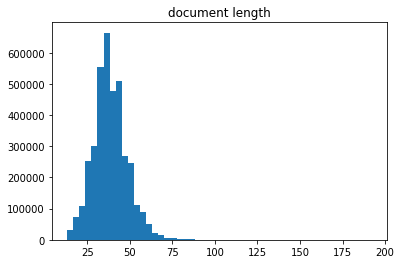

In [18]:
import matplotlib.pyplot as plt
plt.hist(lengths, 50)
plt.title(key +' length')
plt.show()